# Meteorological Data Visualization Tool / Инструмент визуализации метеорологических данных


Button(description='Check available years', layout=Layout(height='40px', width='30%'), style=ButtonStyle())

Checkbox(value=False, description='2007')

Checkbox(value=False, description='2008')

Checkbox(value=False, description='2009')

Checkbox(value=False, description='2010')

Checkbox(value=False, description='2011')

Checkbox(value=False, description='2012')

Checkbox(value=False, description='2013')

Checkbox(value=False, description='2014')

Checkbox(value=False, description='2015')

Checkbox(value=False, description='2016')

Checkbox(value=False, description='2017')

Checkbox(value=False, description='2018')

Checkbox(value=False, description='2019')

Checkbox(value=False, description='TMP_2019')

Button(description='Confirm years', style=ButtonStyle())

Checkbox(value=False, description='08_2007')

Checkbox(value=False, description='09_2007')

Checkbox(value=False, description='10_2007')

Checkbox(value=False, description='11_2007')

Checkbox(value=False, description='12_2007')

Checkbox(value=False, description='01_2008')

Checkbox(value=False, description='02_2008')

Checkbox(value=False, description='03_2008')

Checkbox(value=False, description='04_2008')

Checkbox(value=False, description='05_2008')

Checkbox(value=False, description='06_2008')

Checkbox(value=False, description='07_2008')

Checkbox(value=False, description='08_(1--7)_2008')

Checkbox(value=False, description='09_(15--30)_2008')

Checkbox(value=False, description='10_2008')

Checkbox(value=False, description='11_2008')

Checkbox(value=False, description='12_(1--7)_2008')

Checkbox(value=False, description='12_(12--31)_2008')

LoadedButton(description='Confirm months', style=ButtonStyle())

SelectionRangeSlider(description='Select range:', index=(0, 8613), layout=Layout(width='initial'), options=(da…

Button(description='Confirm range', style=ButtonStyle())

RadioButtons(description='Choose the data interval (how to group the data):', index=2, layout=Layout(width='in…

LoadedButton(description='Confirm interval', style=ButtonStyle())

       Temperature, °C  Southern Wind Speed, m/s  Eastern Wind Speed, m/s  \
count     1.379785e+07              1.379785e+07             1.379785e+07   
mean     -1.223829e+01              4.203283e+00            -1.588872e+00   
std       1.849987e+00              2.079260e+00             1.596312e+00   
min      -1.695000e+01             -7.690000e+00            -1.572000e+01   
25%      -1.362000e+01              2.820000e+00            -2.580000e+00   
50%      -1.177000e+01              4.000000e+00            -1.570000e+00   
75%      -1.106000e+01              5.410000e+00            -5.300000e-01   
max      -7.550000e+00              1.849000e+01             1.203000e+01   

       Vertical Wind Speed, m/s  Atmospheric Pressure, mmHg  \
count              1.379785e+07                1.379785e+07   
mean               9.590727e-01                7.527096e+02   
std                9.550650e-01                1.876334e+00   
min               -7.200000e+00                7.49500

RadioButtons(description='Choose the field you want:', layout=Layout(width='initial'), options=('Temperature, …

Button(description='Show full data graph', layout=Layout(height='40px', width='40%'), style=ButtonStyle())

First record:
2007-12-31 00:00:53.747000
Last record:
2008-01-01 23:50:46.507500


Button(description='Show grouped data graph', layout=Layout(height='40px', width='40%'), style=ButtonStyle())

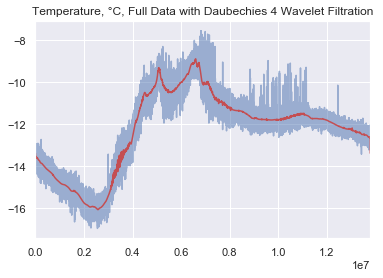

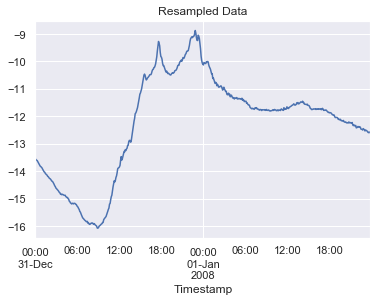

In [1]:
%matplotlib inline

from bs4 import BeautifulSoup
import requests
import re
import numpy as np
import pandas as pd
from io import BytesIO
import datetime
import ipywidgets as widgets
from ipywidgets import widgets as wd
from IPython.display import display, clear_output
from traitlets import traitlets

import matplotlib.pyplot as plt
import pywt
from statsmodels.robust import mad
import seaborn as sns

sns.set(style='darkgrid')
output = widgets.Output()
interval_dict = {'1 second': 'S', '1 minute': 'T', '10 minutes': '5T',
                 '30 minutes': '30T', '1 hour': 'H', '12 hours': '12H',
                 '1 day': 'D', '1 week': 'W', '1 month': 'M', 
                 '3 months': 'Q', '6 months': '2Q', '1 year': 'A'}

#Progress bar widget, from https://github.com/kuk/log-progress
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

#Special button class with variable 
#from https://stackoverflow.com/questions/45188464/return-output-of-the-function-executed-on-click
class LoadedButton(wd.Button):
    """A button that can holds a value as a attribute."""

    def __init__(self, value=None, *args, **kwargs):
        super(LoadedButton, self).__init__(*args, **kwargs)
        # Create the value attribute.
        self.add_traits(value=traitlets.Any(value))

#URL for the main directory:
url = 'http://amk030.imces.ru/meteodata/AMK_030_BIN/'

#Create a data type to extract the timestamp:
timestamp_type = np.dtype([('year', 'i2'),
                           ('month', 'i2'),
                           ('day', 'i2'),
                           ('hour', 'i2'),
                           ('minute', 'i2'),
                           ('second', 'i2'),
                           ('millisecond', 'i2')])

#Create a data type with the binary data format and the desired column names:
raw_data_type = np.dtype([('Temperature, °C', 'i2'),
                          ('Southern Wind Speed, m/s', 'i2'),
                          ('Eastern Wind Speed, m/s', 'i2'),
                          ('Vertical Wind Speed, m/s', 'i2'),
                          ('Atmospheric Pressure, mmHg', 'i2'),
                          ('Relative Air Humidity, %', 'i2'),
                          ('Error (0-9)', 'i1')])

#Function for creation the relevant links available in the main directory:
def MainDirectory(url):
    page = requests.get(url).text
    soup = BeautifulSoup(page, 'html.parser')
    return [node.get('href').rstrip('/') 
            for node in soup.find_all('a') 
            if re.search(r'[0-9]/$|\)/$', node.get('href'))]

#Function for retrieving links to binary files,
#checking for the 'B' at the end:
def FileDirectory(url):
    page = requests.get(url).text
    soup = BeautifulSoup(page, 'html.parser')
    return [url + '/' + node.get('href') 
            for node in soup.find_all('a') 
            if node.get('href').endswith('B')]

#Function for timestamps:
def Timestamps_Function(file, length):
    try:
        #raw_timestamp = np.frombuffer(file, dtype=timestamp_type, count=1)
        raw_timestamp = np.frombuffer(file[:14], dtype=timestamp_type)
        timestamp_elements = list(raw_timestamp[0].tolist())
        timestamp_elements[6] = timestamp_elements[6]*1000
        initial_date = datetime.datetime(*map(int, timestamp_elements))
        timestamps.append(initial_date)
        for i in range(length-1): 
            timestamps.append(timestamps[-1] + datetime.timedelta(milliseconds=12.5))
    except:
        pass

#Function for retrieving full data of each file:
def Data_Array(url):
    try:
        r = requests.get(url)
        file = r.content
        raw_data = file[17:-14]
        subarray = np.frombuffer(raw_data, dtype=raw_data_type)
        Timestamps_Function(file, len(subarray))
        return subarray
    except:
        pass

#Function for Wavelet Filtration, 
#from https://www.kaggle.com/jeffreyegan/vsb-power-line-fault-detection-approach/data

def waveletSmooth(x, wavelet="db4", level=10, title=None):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec(x, wavelet, mode="per" )
    # calculate a threshold
    sigma = mad(coeff[-level])
    # changing this threshold also changes the behavior,
    # but I have not played with this very much
    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="per" )
    f, ax = plt.subplots()
    plt.plot( x, color="b", alpha=0.5 )
    plt.plot( y, color="r" )
    if title:
        ax.set_title(title)
    ax.set_xlim((0,len(y)))

#Create the lists:
available_years = MainDirectory(url)
selected_years = []
available_months = []
selected_months = []
file_directory = []
days_list = []
date_selection = []
timestamps = []
df = pd.DataFrame()


start_button = widgets.Button(description='Check available years',
                             layout=widgets.Layout(width='30%', height='40px'))
years_button = widgets.Button(description='Confirm years')
months_button = LoadedButton(description='Confirm months')
range_button = widgets.Button(description='Confirm range')
interval = widgets.RadioButtons(
    options=['1 second', '1 minute', '10 minutes', '30 minutes', '1 hour', 
            '12 hours', '1 day', '1 week', '1 month', '3 months', '6 months', '1 year'],
    value='10 minutes',
    description='Choose the data interval (how to group the data):',
    layout={'width': 'initial'},
    style = {'description_width': 'initial'},
    disabled=False)
interval_button = LoadedButton(description='Confirm interval')
fields = widgets.RadioButtons(
    options=['Temperature, °C', 'Southern Wind Speed, m/s', 'Eastern Wind Speed, m/s',
            'Vertical Wind Speed, m/s', 'Atmospheric Pressure, mmHg', 'Relative Air Humidity, %'],
    value='Temperature, °C',
    description='Choose the field you want:',
    layout={'width': 'initial'},
    style = {'description_width': 'initial'},
    disabled=False)
graph1_button = widgets.Button(description='Show full data graph', 
                               layout=widgets.Layout(width='40%', height='40px',
                                                    positioning = 'bottom'))
graph2_button = widgets.Button(description='Show grouped data graph', 
                               layout=widgets.Layout(width='40%', height='40px'))


def start_button_clicked(_):
    for i in log_progress(range(len(available_years)), every=1):
        selected_years.append(widgets.Checkbox(description = available_years[i]))
        display(selected_years[i])
    display(years_button)

def years_button_clicked(_):
    for i in log_progress(range(len(available_years))):
        if selected_years[i].value == True:
            available_months.extend(MainDirectory(url + available_years[i] + '/'))
    for i in log_progress(range(len(available_months))):
        selected_months.append(widgets.Checkbox(description = available_months[i]))
        display(selected_months[i])
    display(months_button)
        
def months_button_clicked(button):
    for i in log_progress(range(len(available_months))):
        if selected_months[i].value == True:
            file_directory.extend(
                FileDirectory(
                    url + re.search(r'\d{4}', available_months[i]).group(0) 
                    + '/' + available_months[i] + '/'))
    days_aux = [datetime.date(int('20' + file_directory[i][-3:-1]),
                              int(file_directory[i][-12:-10]),
                              int(file_directory[i][-10:-8]))
                for i in log_progress(range(len(file_directory)))]
    date_selection = widgets.SelectionRangeSlider(
        options=days_aux,
        index=(0, len(days_aux)-1),
        description='Select range:',
        disabled=False,
        layout={'width': 'initial'})
    days_list.extend(days_aux)    
    display(date_selection)
    display(range_button)
    button.value = date_selection
    
def range_button_clicked(_):
    display(interval)
    display(interval_button)

    
def interval_button_clicked(button):
    date_selection = months_button.value.value
    frames = [Data_Array(i) for i in log_progress(file_directory[days_list.index(date_selection[0]):
                len(days_list) - 1 - days_list[::-1].index(date_selection[1])])]
    data = np.concatenate(frames)
    df = pd.DataFrame(data, columns=data.dtype.names)
    df['Temperature, °C'] = df['Temperature, °C'].apply(lambda x: x/100)
    df['Southern Wind Speed, m/s'] = df['Southern Wind Speed, m/s'].apply(lambda x: x/100)
    df['Eastern Wind Speed, m/s'] = df['Eastern Wind Speed, m/s'].apply(lambda x: x/100)
    df['Vertical Wind Speed, m/s'] = df['Vertical Wind Speed, m/s'].apply(lambda x: x/100)
    df['Atmospheric Pressure, mmHg'] = df['Atmospheric Pressure, mmHg'].apply(lambda x: x/10)
    df['Relative Air Humidity, %'] = df['Relative Air Humidity, %'].apply(lambda x: x/100)
    df['Timestamp'] = timestamps
    print(df.describe())
    display(fields)
    display(graph1_button)
    button.value = df

def graph1_button_clicked(_):
    #df = interval_button.value
    waveletSmooth(interval_button.value[fields.value], title=fields.value + 
                  ', Full Data with Daubechies 4 Wavelet Filtration')
    interval_button.value.set_index('Timestamp', inplace = True)
    print('First record:')
    print(interval_button.value.index[0])
    print('Last record:')
    print(interval_button.value.index[-1])
    display(graph2_button)
    
def graph2_button_clicked(_):
    interval_button.value[fields.value].resample(interval_dict[interval.value]).mean().dropna().plot(title='Resampled Data')

start_button.on_click(start_button_clicked)
display(start_button)

years_button.on_click(years_button_clicked)
months_button.on_click(months_button_clicked)
interval_button.on_click(interval_button_clicked)
range_button.on_click(range_button_clicked)
graph1_button.on_click(graph1_button_clicked)
graph2_button.on_click(graph2_button_clicked)